# Filtro de Kalman ND

In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

from StateSpaceDisplay import state_space_display, state_space_display_updated

## Función gaussiana multivariable

En muchos casos es necesario seguir más de una variable, para ello, se modela la distribución sobre el espacio de estados como una distribución Gaussiana multivariable.

\begin{eqnarray}
f(x_{i}|\mu,\Sigma) & =\nonumber \\
 & = & f((x_{i1},x_{i2},...,x_{in})'\,|\,\mu=(\mu_{1},...,\mu_{n})',\Sigma=\left[\begin{array}{ccc}
\sigma_{1}^{2} &  & \sigma_{1n}\\
 & \ddots\\
\sigma_{n1} &  & \sigma_{n}^{2}
\end{array}\right])\nonumber \\
 &  & =\frac{1}{\sqrt{(2\pi)^{n}|\Sigma|}}exp(-\frac{1}{2}(x_{i}-\mu)^T \Sigma^{-1}(x_{i}-\mu))
\end{eqnarray}

Obsevemos el comportamiento de una distribución Gaussiana multivariable.

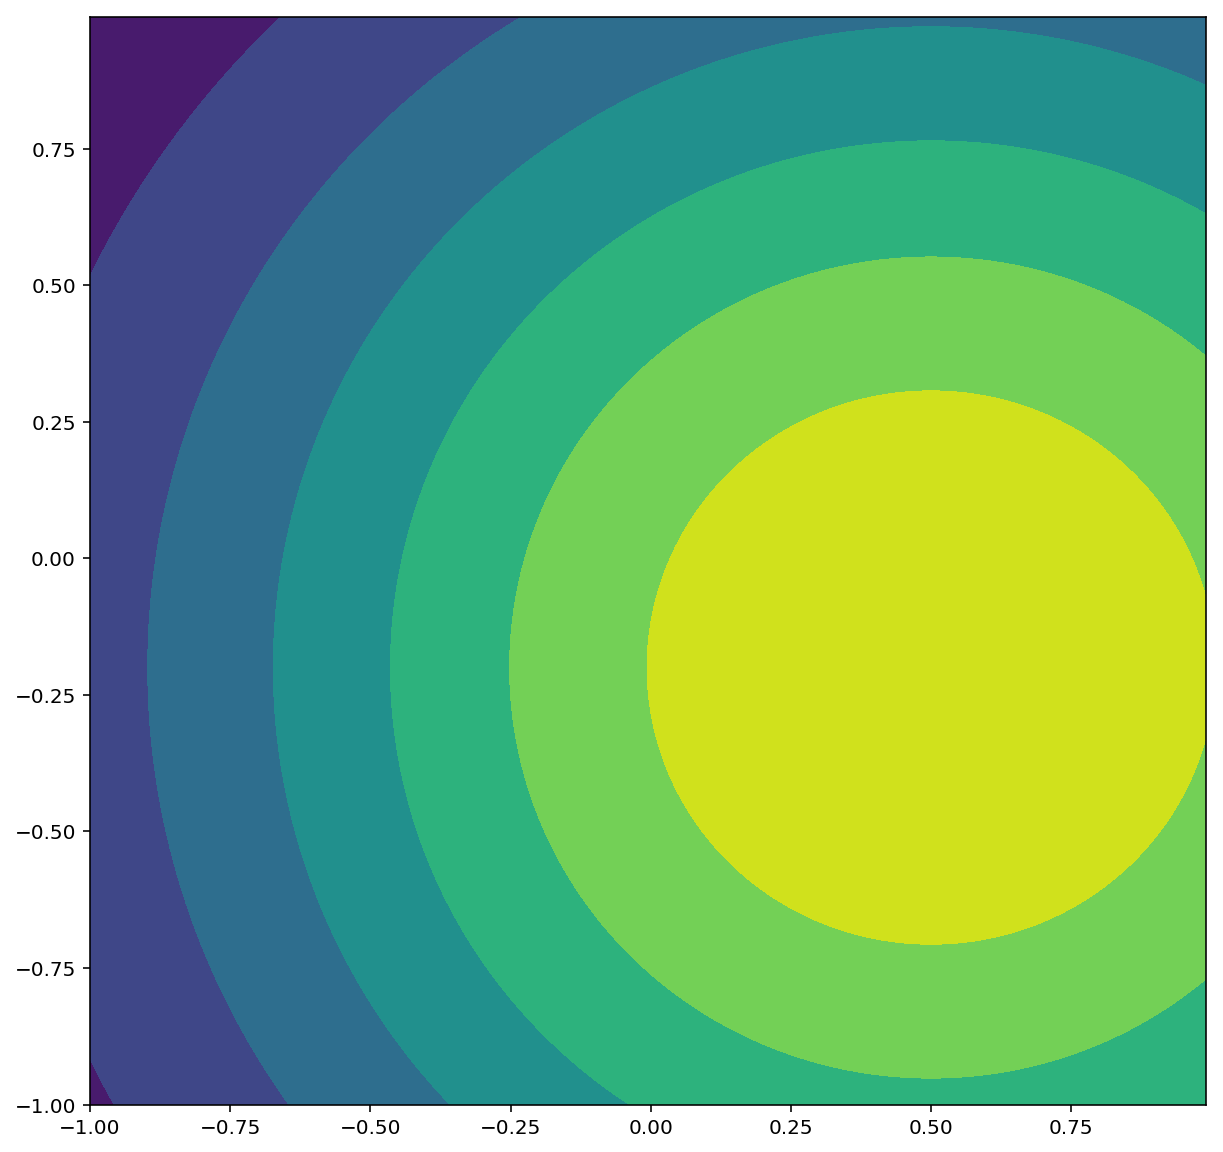

In [2]:
# parámetros de la distribución normal multivariable
media = [0.5, -0.2]
# variables independientes

covarianza = [[1, 0.0], [0.0, 1]]

## variables correlacionadas
#covarianza = [[2.0, 0.3], [0.3, 0.5]]
#covarianza = [[1, -0.5], [-0.5, 1]]

## alta incertidumbre en una dimensión
#covarianza = [[0.1, 0.0], [0.0, 1]]

x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

# objeto con una función de distribución normal multivariable
rv = multivariate_normal(media, covarianza)

# graficar
plt.figure(figsize=(10,10))
plt.contourf(x, y, rv.pdf(pos))
plt.show()

## Prediccción

Como ejemplo seguiremos un objeto que se desplaza en una sola dimensión, eje x, por lo tanto su estado lo escribiremos como el vector de la posición y su velocidad $x=(x, \dot{x})$. 

Si pudieramos controlar el objeto, éste control estaría dado por la aceleración que se le imprime, $u = \ddot{x}$. 

El Filtro de Kalman necesita de dos tipos de incertidumbre para funcionar:

* observación - precisión del sensor
* movimiento - modela la capacidad del sistema de ejecutar un movimiento. En el caso de tracking podemos indicar que tal fieles son los movimientos del objeto dado su estado más probable.

The transition function has the following form:

$$
g(x_t,u_t,\Delta t) = \begin{bmatrix} 1 & 0 \\ \Delta t & 1 \end{bmatrix} \begin{bmatrix} \dot{z}\\z \end{bmatrix} + \begin{bmatrix} \Delta t \\ 0 \end{bmatrix} \begin{bmatrix} \ddot{z} \end{bmatrix}  = A_t \mu_{t-1}+B_tu_t
$$

The partial derivative of the $g$ relative to each component is:

$$
g'(x_t,u_t,\Delta t) = \begin{bmatrix} 1 & 0 \\ \Delta t & 1   \end{bmatrix}
$$

$A$ and $B$ matrices, in general, depend on the external parameters we declare them as the separate functions.


In [3]:
class KF:
    def __init__(self,
                 sensor_sigma,             # Sensor noise
                 velocity_sigma,           # Velocity uncertainty
                 position_sigma,           # Position uncertainty
                 dt                        # dt time between samples 
                ):
        
        # Sensor measurement covariance
        self.r_t = np.array([[sensor_sigma**2]])
        
        # Motion model noise for velocity and position
        self.q_t = np.array([[velocity_sigma**2,0.0],
                             [0.0,position_sigma**2]]) 
        self.dt = dt
        
        self.mu = np.array([0.0])
        self.sigma = np.array([0.0])
        
        self.mu_bar = self.mu
        self.sigma_bar = self.sigma

    @property
    def a(self):
        return np.array([[1.0, self.dt],
                         [0, 1.0]])

    @property
    def b(self):
        return np.array([[self.dt],
                         [0.0]])

    def g(self, 
          previous_mu, # Previous mu
          u            # Control input \ddot{z}
          ):
        '''Generates the transition function for the height. '''
        # TODO: return the g matrix using A and B matrixes 
        return np.matmul(self.a, previous_mu) + self.b * u

    def g_prime(self):
        '''The derivative of the transition function.'''
        # TODO: return the derivative of the g matrix
        return np.array([[1.0, 0.0],
                         [self.dt, 1.0]])


    def initial_values(self, 
                       mu_0, 
                       sigma_0):

        '''Setting initial values for the mu and sigma of the KF'''

        self.mu = mu_0
        self.sigma = sigma_0



    def predict(self, 
                u             # Control input 
               ):

        '''Prediction step of the KF filter '''

        # TODO: Follow the prediction steps outlined in theoretical part of the lesson and implement the next variables. 
        # mu_bar = None
        # g_now  = None
        # sigma_bar = None

        mu_bar = self.g(self.mu, u)
        g_now  = self.g_prime()
        sigma_bar = np.matmul(g_now, np.matmul(self.sigma, np.transpose(g_now))) + self.q_t

        self.mu_bar = mu_bar
        self.sigma_bar = sigma_bar

        return mu_bar, sigma_bar
    
    def h_prime(self):
        return np.array([[1.0, 0.0]])
    
    def h(self,mu):
        return np.matmul(np.array([[1.0, 0.0]]), mu) 

    def update(self, z):
    
        # TODO: Follow the update step outlined in theoretical part of the lesson and implement the next variables. 
        # H = None 
        # K = None
    
        # mu = None
        # sigma = None
    
     
        H = self.h_prime()
        S = np.matmul(np.matmul(H, self.sigma_bar), np.transpose(H)) + self.r_t     
        K = np.matmul(np.matmul(self.sigma_bar, np.transpose(H)), np.linalg.inv(S))
    
        mu = self.mu_bar + np.matmul(K, (z - self.h(self.mu_bar)))
        sigma = np.matmul((np.identity(2) - np.matmul(K, H)), self.sigma_bar)
    
        self.mu = mu
        self.sigma = sigma
    
        return mu, sigma

In [4]:
z = 0.0                         # Initial position
v = 0.0                         # Initial velocity
dt = 1.0                        # The time difference between measures
sensor_error = 0.1              # Sensor sigma
velocity_sigma = 0.1            # Velocity uncertainty
position_sigma = 0.1            # Position uncertainty


mu_0 = np.array([[z],
                 [v]]) 

sigma_0 = np.array([[velocity_sigma**2, 0.0],
                    [0.0, position_sigma**2]])

u = np.array([[0.0],
              [0.0]])     # no control input is given \ddot{z} = 0 

In [5]:
# Initialize the object
MYKF = KF(sensor_error, velocity_sigma, position_sigma, dt)

# Input the initial values 
MYKF.initial_values(mu_0, sigma_0)

# Call the predict function
mu_bar, sigma_bar = MYKF.predict(u)

print('mu_bar = \n', mu_bar)
print('sigma_bar = \n', sigma_bar)

mu_bar = 
 [[ 0.]
 [ 0.]]
sigma_bar = 
 [[ 0.02  0.01]
 [ 0.01  0.03]]


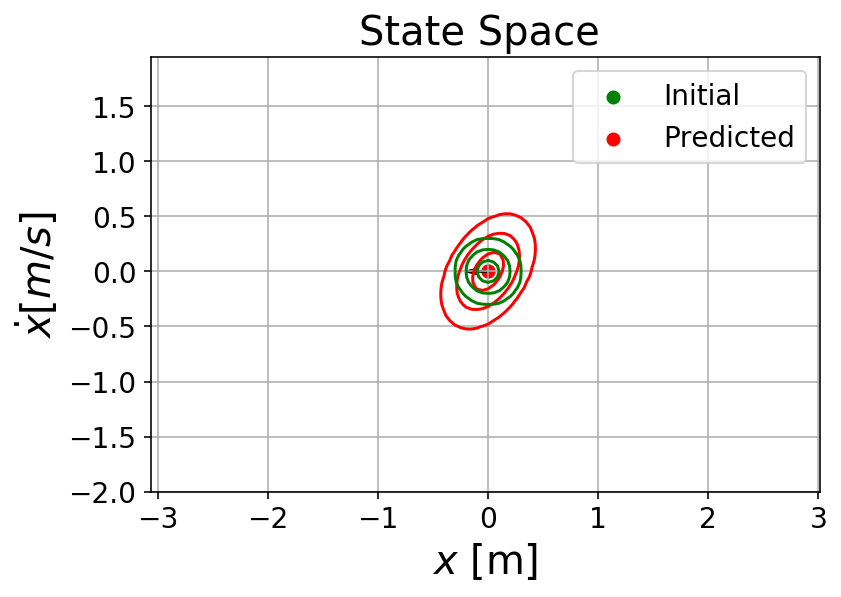

In [6]:
state_space_display(z, v, mu_0, sigma_0, mu_bar, sigma_bar)

In [7]:
measure = 1.01 # only measuring the x coordinate

mu_updated, sigma_updated = MYKF.update(measure)

print('updated mean = \n', mu_updated)
print('updated sigma = \n', sigma_updated)

updated mean = 
 [[ 0.67333333]
 [ 0.33666667]]
updated sigma = 
 [[ 0.00666667  0.00333333]
 [ 0.00333333  0.02666667]]


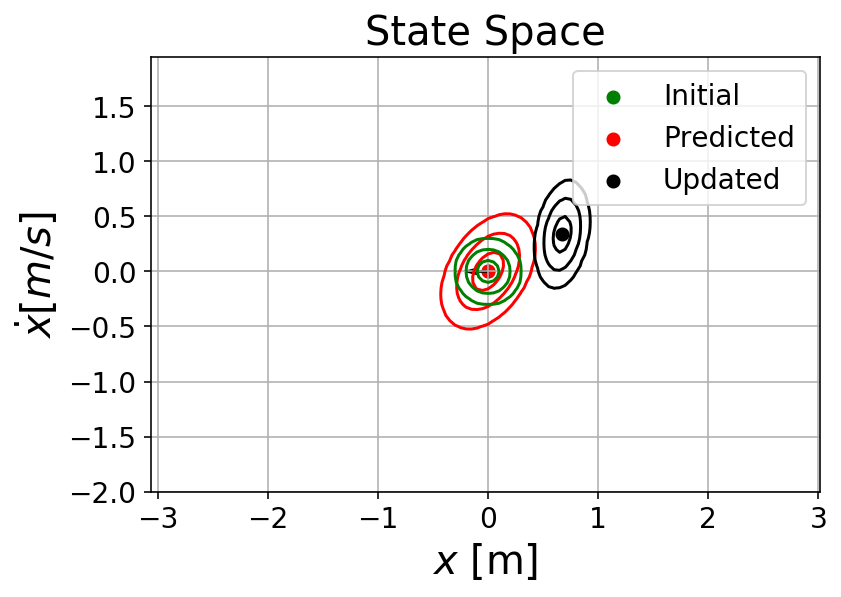

In [8]:
state_space_display_updated(z, v, mu_0, sigma_0, mu_bar, sigma_bar, mu_updated, sigma_updated)